# Scenario 4 model built with MIRA

In [1]:
import sympy
import numpy
import matplotlib.pyplot as plt

from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.viz import GraphicalModel
from mira.modeling.ode import OdeModel, simulate_ode_model
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json


# Step 1: start with a minimal model of microbial growth

In [2]:
species = lambda: Concept(name='x')
intrinsic = NaturalReplication(subject=species())
intrinsic.set_mass_action_rate_law('r')
interaction = ControlledReplication(controller=species(),
                                    subject=species())
interaction.set_mass_action_rate_law('a')
initial = Initial(concept=species(), expression=sympy.Float(1))
params = {'r': Parameter(name='r', value=1), 'a': Parameter(name='a', value=1)}

In [3]:
tm = TemplateModel(templates=[intrinsic, interaction],
                   initials={'x': initial},
                   parameters=params)

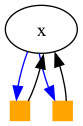

In [4]:
GraphicalModel.for_jupyter(tm)

## Step 2: stratify the minimal model into 4 and then 6 species

We capture model parameters and initial conditions here for all 6 species (the 4 species case is a subset of it).

In [5]:
r_i = [0.53, 0.42, 0.49, 0.33, 0.7, 0.3]
x0_i = [0.51, 0.39, 0.88, 0.4, 0.2, 0.8]
a_ij = [
    [  -0.5, - 0.01, 0.002, -0.009, -0.002,  0.01],
    [     0,   -0.5,     0, -0.169,      0,     0],
    [-0.002, -0.003,  -0.5,   0.02,   0.03, -0.04],
    [     0, -0.226, -0.04,   -0.5,      0,  0.01],
    [     0,   -0.1, -0.02,      0,   -0.5,     0],
    [     0,  -0.04, -0.05,      0,      0,  -0.5]
]

In [6]:
# Stratify into 4 species
tm_strat4 = stratify(tm, key='species',
                     strata=[str(i) for i in range(1, 5)],
                     structure=[],
                     cartesian_control=True)

# Stratify into 6 species
tm_strat6 = stratify(tm, key='species',
                     strata=[str(i) for i in range(1, 7)],
                     structure=[],
                     cartesian_control=True)

Model structure for 4-species model

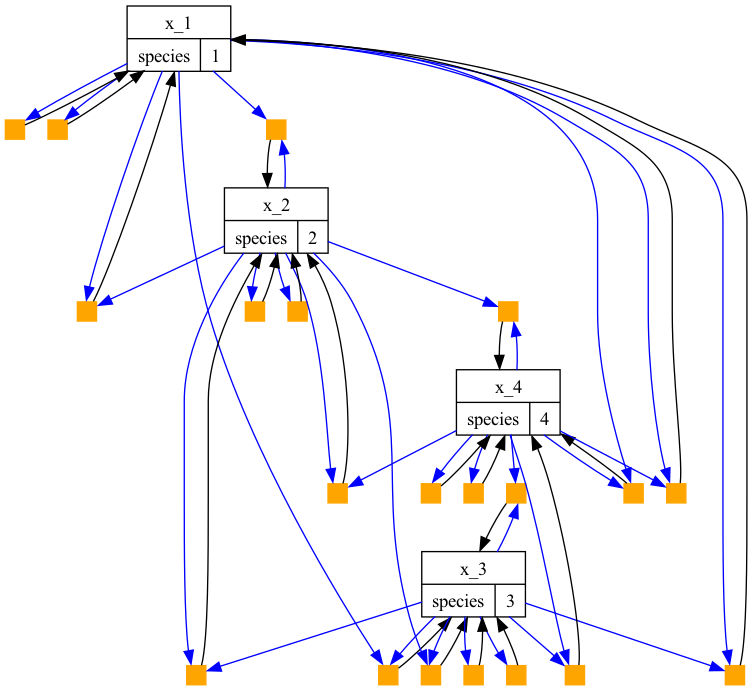

In [7]:
GraphicalModel.for_jupyter(tm_strat4)

Model structure for 6-species model

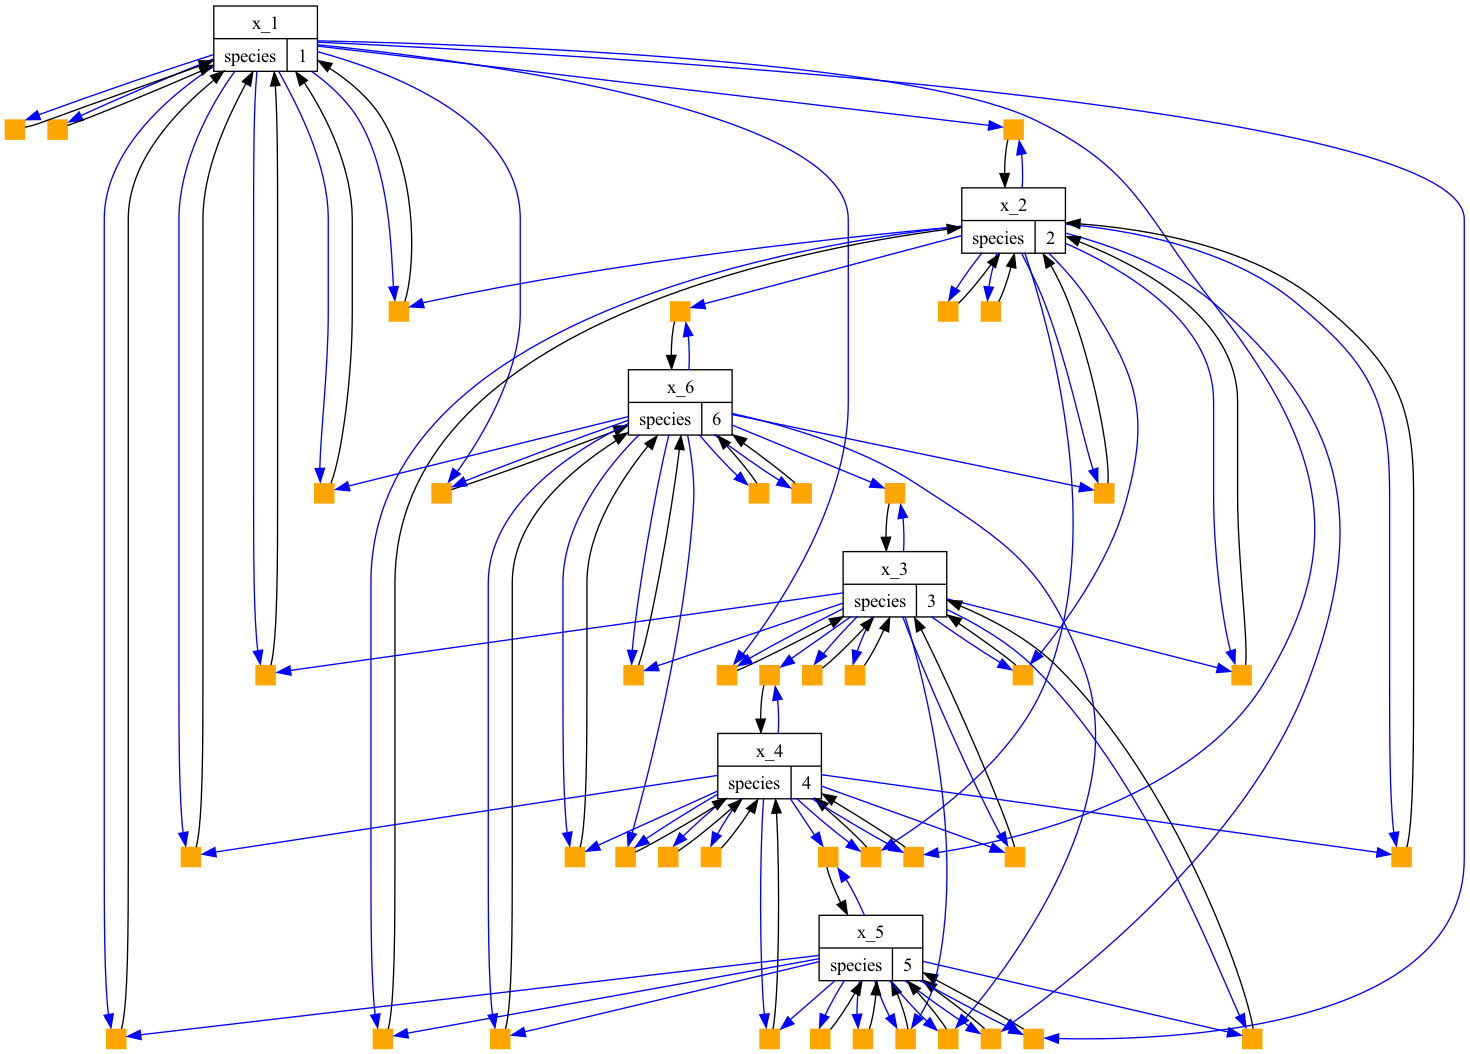

In [8]:
GraphicalModel.for_jupyter(tm_strat6)

Reparameterize stratified models based on provided parameters

In [9]:
# This code takes care of correctly reparameterizing the model
# after stratification
for tm_strat in [tm_strat4, tm_strat6]:
    for idx, init in enumerate(tm_strat.initials.values()):
        init.expression = SympyExprStr(sympy.Float(x0_i[idx]))
    for template in tm_strat.templates:
        ints = [int(i.context['species']) for i in template.get_interactors()]
        param = list(template.get_parameter_names())[0]
        if param.startswith('r'):
            tm_strat.parameters[param].value = r_i[ints[0]-1]
        else:
            tm_strat.parameters[param].value = a_ij[ints[1]-1][ints[0]-1]      

## Step 3: assemble models into ODEs and simulate
### Step 3.1: 4-species system

In [10]:
om = OdeModel(Model(tm_strat4), initialized=True)

These are the RHS equations of the 4-species ODE system without substitution

In [11]:
om.kinetics

Matrix([
[    p[0, 0]*y[0, 0] + p[4, 0]*y[0, 0]**2 + p[5, 0]*y[0, 0]*y[1, 0] + p[6, 0]*y[0, 0]*y[2, 0] + p[7, 0]*y[0, 0]*y[3, 0]],
[  p[1, 0]*y[1, 0] + p[8, 0]*y[1, 0]**2 + p[9, 0]*y[0, 0]*y[1, 0] + p[10, 0]*y[1, 0]*y[2, 0] + p[11, 0]*y[1, 0]*y[3, 0]],
[p[2, 0]*y[2, 0] + p[12, 0]*y[2, 0]**2 + p[13, 0]*y[0, 0]*y[2, 0] + p[14, 0]*y[1, 0]*y[2, 0] + p[15, 0]*y[2, 0]*y[3, 0]],
[p[3, 0]*y[3, 0] + p[16, 0]*y[3, 0]**2 + p[17, 0]*y[0, 0]*y[3, 0] + p[18, 0]*y[1, 0]*y[3, 0] + p[19, 0]*y[2, 0]*y[3, 0]]])

In [12]:
ts = numpy.linspace(0, 30, 100)
res = simulate_ode_model(om, times=ts)

These are the RHS equations of the 4-species ODE system with substitution

In [13]:
om.kinetics

Matrix([
[-0.5*y[0, 0]**2 - 0.01*y[0, 0]*y[1, 0] + 0.002*y[0, 0]*y[2, 0] - 0.009*y[0, 0]*y[3, 0] + 0.53*y[0, 0]],
[                                               -0.5*y[1, 0]**2 - 0.169*y[1, 0]*y[3, 0] + 0.42*y[1, 0]],
[-0.002*y[0, 0]*y[2, 0] - 0.003*y[1, 0]*y[2, 0] - 0.5*y[2, 0]**2 + 0.02*y[2, 0]*y[3, 0] + 0.49*y[2, 0]],
[                        -0.226*y[1, 0]*y[3, 0] - 0.04*y[2, 0]*y[3, 0] - 0.5*y[3, 0]**2 + 0.33*y[3, 0]]])

Simulation results for the 4-species system

Text(0, 0.5, 'Proportion')

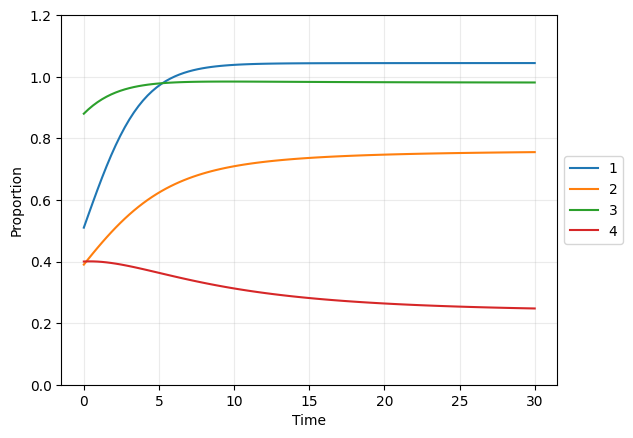

In [14]:
plt.plot(ts, res, label=range(1,5))
plt.ylim([0, 1.2])
plt.grid(alpha=0.25)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Proportion')

### Step 3.2: 6-species system

In [15]:
om = OdeModel(Model(tm_strat6), initialized=True)

In [16]:
res = simulate_ode_model(om, times=numpy.linspace(0, 30, 100))

In [17]:
om.kinetics

Matrix([
[-0.5*y[0, 0]**2 - 0.01*y[0, 0]*y[1, 0] + 0.002*y[0, 0]*y[2, 0] - 0.009*y[0, 0]*y[3, 0] - 0.002*y[0, 0]*y[4, 0] + 0.01*y[0, 0]*y[5, 0] + 0.53*y[0, 0]],
[                                                                                              -0.5*y[1, 0]**2 - 0.169*y[1, 0]*y[3, 0] + 0.42*y[1, 0]],
[ -0.002*y[0, 0]*y[2, 0] - 0.003*y[1, 0]*y[2, 0] - 0.5*y[2, 0]**2 + 0.02*y[2, 0]*y[3, 0] + 0.03*y[2, 0]*y[4, 0] - 0.04*y[2, 0]*y[5, 0] + 0.49*y[2, 0]],
[                                                -0.226*y[1, 0]*y[3, 0] - 0.04*y[2, 0]*y[3, 0] - 0.5*y[3, 0]**2 + 0.01*y[3, 0]*y[5, 0] + 0.33*y[3, 0]],
[                                                                          -0.1*y[1, 0]*y[4, 0] - 0.02*y[2, 0]*y[4, 0] - 0.5*y[4, 0]**2 + 0.7*y[4, 0]],
[                                                                         -0.04*y[1, 0]*y[5, 0] - 0.05*y[2, 0]*y[5, 0] - 0.5*y[5, 0]**2 + 0.3*y[5, 0]]])

Text(0, 0.5, 'Proportion')

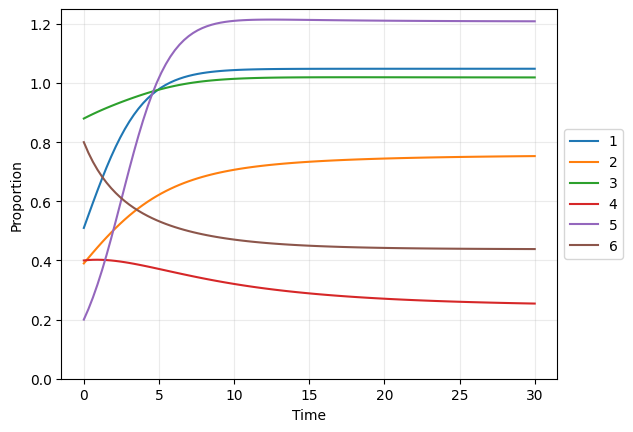

In [18]:
plt.plot(ts, res, label=range(1,7))
plt.ylim([0, 1.25])
plt.grid(alpha=0.25)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Proportion')

## Part 4. Export models into exchange formats

In [19]:
frameworks = {'regnet': template_model_to_regnet_json, 'petrinet': template_model_to_petrinet_json}
models = {'4spec': tm_strat4, '6spec': tm_strat6}

for mkey, model in models.items():
    for fkey, fun in frameworks.items():
        with open(f'scenario4_{mkey}_{fkey}.json', 'w') as fh:
            json.dump(fun(model), fh, indent=1)